# Bayesian amplitude regression

This jupyter notebook was taken from one of the tutorials of Tilman's lecture series about Machine Learning and particel physics (2022). Main author of this jupyter notebook is Barry Dillan. I (Michel) slightly modified it and put a few more explanations in there. It covers the techincal aspects of how to implement a Bayesian Neural network in pytorch. 

We will start by constructing a Bayesian layer in pytorch, and then building the Bayesian loss function.  We will then construct a Bayesian network from these layers, and use it to perform amplitude regression.  We will discuss how to analyse the outputs of the Bayesian network, and how this gives us the ability to estimate the error on our analysis.  This last step is crucial to the application of any numerical technique in physics.

#### Outline / tasks:
 - Imports \& plotting set-up
 - Loading the data
 - Visualising the data
     - visualise some of the kinematics of the process (transverse momentum of photons/gluons, MET)
     - histogram the amplitudes
 - Preprocessing the data
     - neural networks like $\mathcal{O}(1)$ numbers
     - how should we preprocess the data?
 - Datasets and dataloaders
     - details are in the pytorch docs

     
Most practical pytorch skills you need for this work is covered in the basics tutorial at https://pytorch.org/tutorials/beginner/basics/intro.html.

### Imports

In [1]:
import os
import sys
import random
import time
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F
from torch.nn import init
from torch.nn import Module
from torch import jit as jtorch
import pandas as pd
from datetime import date

#### Plotting set-up

In [2]:
from matplotlib import pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings("ignore")
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
import matplotlib.colors as mcolors
import colorsys

labelfont = FontProperties()
labelfont.set_family('serif')
labelfont.set_name('Times New Roman')
labelfont.set_size(14)

axislabelfont = FontProperties()
axislabelfont.set_family('serif')
axislabelfont.set_name('Times New Roman')
axislabelfont.set_size(18)

tickfont = FontProperties()
tickfont.set_family('serif')
tickfont.set_name('Times New Roman')
tickfont.set_size(16)

axisfontsize = 16
labelfontsize = 16

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams['text.usetex'] = True

## Saving and file management

In [3]:
project_name = 'MLTopoClusterCalibration'
file_model_ext     = 'pt'               # model file extension (pytorch convention)
file_model_prefix  = 'bayes_regression' # model file name prefix
file_model_version = '09.07.2022_01'    # model version/training sequence 

## Loading the data

In [4]:
training_size = 6000000

In [5]:
if training_size > 0:
    df = pd.read_csv('data/EM_all.csv', delimiter=' ', nrows=training_size)
else:
    df = pd.read_csv('data/EM_all.csv', delimiter=' ')

features = ["clusterEtaCalib",          # input: cluster rapidity          
            "clusterE",                 # input: cluster EM-scale energy
            "cluster_CENTER_LAMBDA",    # input: cluster depth in calorimeter
            "cluster_LONGITUDINAL",     # input: normalized longitudinal compactness measure
            "cluster_LATERAL",          # input: normalized lateral compactness measure
            "cluster_ENG_FRAC_EM",      # input: fraction of energy in EM calorimeter
            "cluster_FIRST_ENG_DENS",   # input: first moment of cell energy densities
            "cluster_SIGNIFICANCE",     # input: overall cluster signal significance
            "cluster_PTD",              # input: cluster fragmentation function
            "cluster_SECOND_TIME",      # input: second moment of cell time distribution
            "avgMu",                    # average number of pile-up collisions contributing to recorded event
            "nPrimVtx",
]

# filter small cluster_ENG_CALIB_TOT
df = df.loc[df["cluster_ENG_CALIB_TOT"] > 0.3]
df = df.loc[df["clusterE"] > 0.]
df = df.loc[df["cluster_FIRST_ENG_DENS"] > 0.]

# filter large response
r = df["clusterE"] / df["cluster_ENG_CALIB_TOT"]
df = df.loc[r < 3]

# define targets/labels and input data
labels = df["clusterE"] / df["cluster_ENG_CALIB_TOT"]   ## this is the EM response - the training target!
e_dep = df["cluster_ENG_CALIB_TOT"]                     ## this is the "true" deposited energy in the cluster
e_had = df["cluster_HAD_WEIGHT"] * df["clusterE"]       ## this is the cluster enegry after hadronic calibration (1. step in LCW)
# convert pandas to numpy arrays
data = df[features].to_numpy()
labels = labels.to_numpy()
e_dep = e_dep.to_numpy()
e_had = e_had.to_numpy()

In [6]:
# data-shape
print("Shapes after cuts: (all shapes should have the same first dimension)")
print(f"Input data .......................: {data.shape}")
print(f"Targets ..........................: {labels.shape}")
print(f"True energy ......................: {e_dep.shape}")
print(f"Hadronically calibrated energy ...: {e_had.shape}")

Shapes after cuts: (all shapes should have the same first dimension)
Input data .......................: (5135091, 12)
Targets ..........................: (5135091,)
True energy ......................: (5135091,)
Hadronically calibrated energy ...: (5135091,)


In [7]:
trn_dat = data
trn_amp = labels

#TODO: this has to be changed! Use different dataset!
val_dat = data
val_amp = labels

#TODO: this has to be changed! Use different dataset!
tst_dat = data
tst_amp = labels

In [8]:
print( f"train data shape: {trn_dat.shape}" )
print( f"train amp  shape: {trn_amp.shape}" )
print( f"test  data shape: {tst_dat.shape}" )
print( f"test  amp  shape: {tst_amp.shape}" )
print( f"val   data shape: {val_dat.shape}" )
print( f"val   amp  shape: {val_amp.shape}" )

train data shape: (5135091, 12)
train amp  shape: (5135091,)
test  data shape: (5135091, 12)
test  amp  shape: (5135091,)
val   data shape: (5135091, 12)
val   amp  shape: (5135091,)


## Visualising the labels

We can plot a histogram of the labels for the training data.

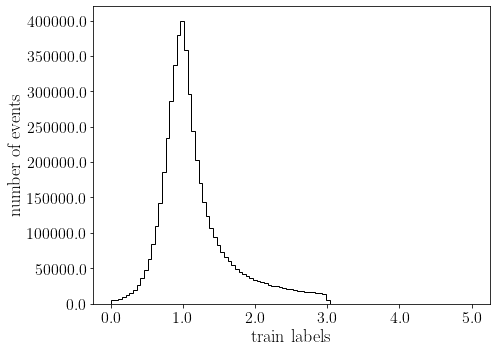

In [10]:
fig, axs = plt.subplots( 1, 1, figsize=(7,5) )

axs.hist( trn_amp, bins=np.linspace(0, 5, 100), histtype='stepfilled', fill=None )

axs.set_xlabel( "train labels", fontproperties=axislabelfont )
axs.set_ylabel( "number of events", fontproperties=axislabelfont )

xticks = axs.get_xticks()
axs.set_xticklabels( xticks, fontproperties=tickfont )

yticks = axs.get_yticks()
axs.set_yticklabels( yticks, fontproperties=tickfont )

fig.tight_layout()

## Visualising the inputfeatures

0 clusterEtaCalib
1 clusterE
2 cluster_CENTER_LAMBDA
3 cluster_LONGITUDINAL
4 cluster_LATERAL
5 cluster_ENG_FRAC_EM
6 cluster_FIRST_ENG_DENS
7 cluster_SIGNIFICANCE
8 cluster_PTD
9 cluster_SECOND_TIME
10 avgMu
11 nPrimVtx


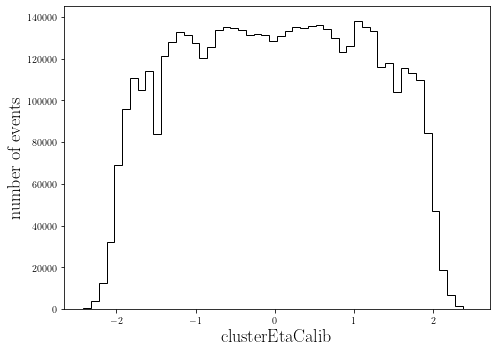

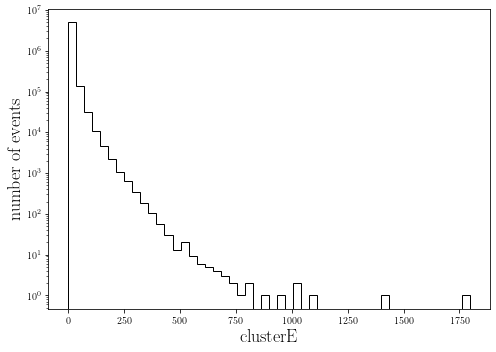

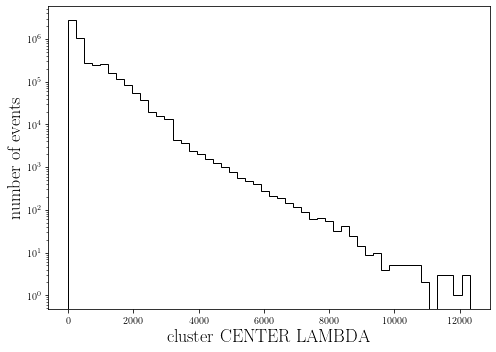

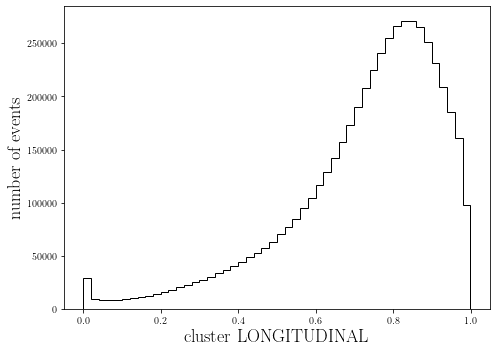

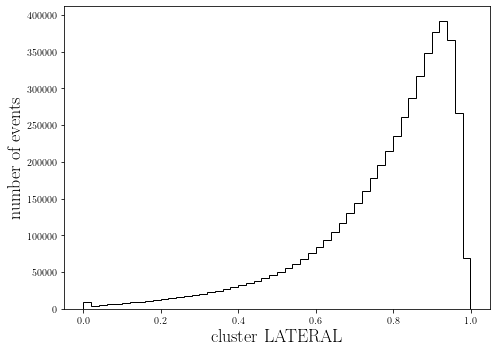

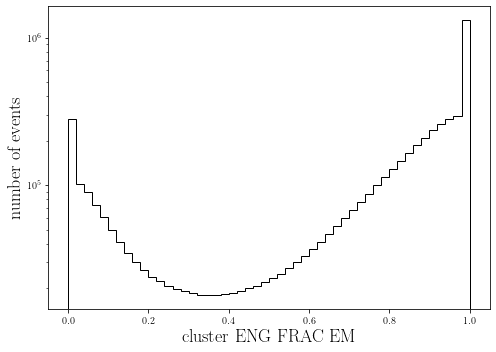

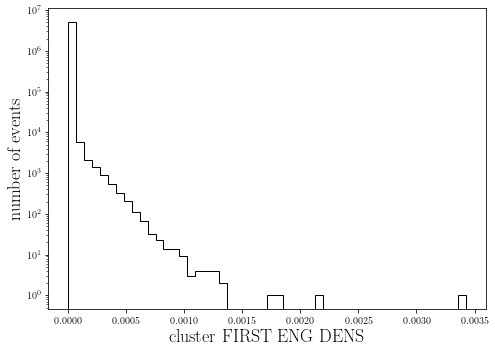

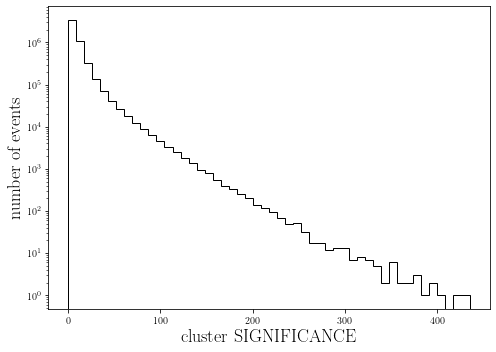

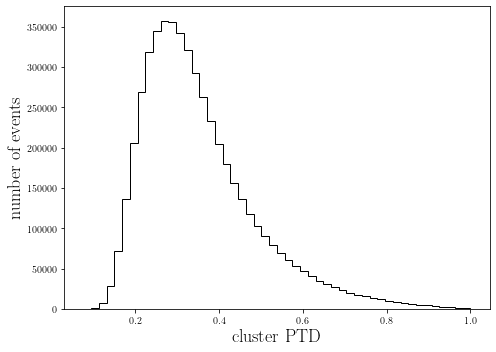

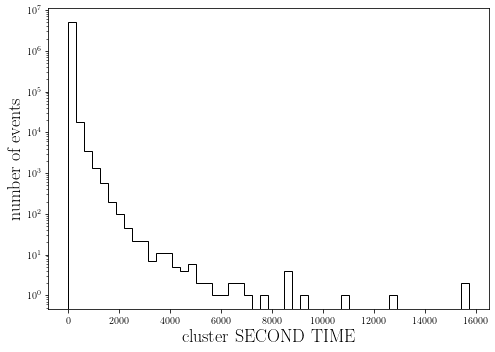

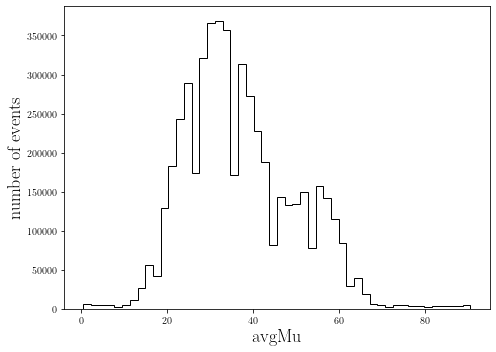

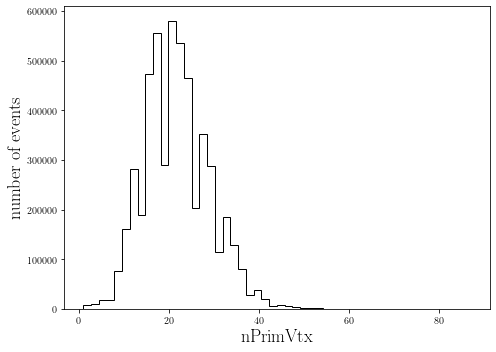

In [11]:
n_bins = 50

nolognames = [ 'clusterEtaCalib', 'cluster_PTD', 'nPrimVtx', 'avgMu', 'cluster_LONGITUDINAL', 'cluster_LATERAL' ]
for i, name in enumerate(features):
    print(i, name)
    fig, axs = plt.subplots( 1, 1, figsize=(7,5) )
    feature = data[:, i]
    axs.hist( feature, bins=n_bins, histtype='stepfilled', fill=None )

    if name not in nolognames:
        axs.set_yscale('log')

    axs.set_xlabel(name.replace("_", " "), fontproperties=axislabelfont )
    axs.set_ylabel("number of events", fontproperties=axislabelfont )

    fig.tight_layout()

## Preprocessing the data

We will be using a dense network, so the data needs to be in vector format.

In [12]:
# This reshaping is not needed any longer!
nev = trn_dat.shape[0]
trn_datf = np.reshape( trn_dat, (nev,-1) )
val_datf = np.reshape( val_dat, (nev,-1) )
tst_datf = np.reshape( tst_dat, (nev,-1) )

Check the shape:

In [13]:
trn_datf.shape

(5135091, 12)

There are further preprocessing steps we can take. We could re-scale the inputs by a constant number, or even take the logarithm of the inputs.

For now, we'll just re-scale by the mean values.

In [14]:
#trn_datf['clusterE']               = np.log10(trn_datf['clusterE'])
#trn_datf['cluster_FIRST_ENG_DENS'] = np.log10(trn_datf['cluster_FIRST_ENG_DENS'])

for idx, lname in enumerate(features):
    if lname == 'clusterE' or lname == 'cluster_FIRST_ENG_DENS':
            #trn_datf_i = trn_datf[:,idx]
            #trn_datf_i.reshape(-1)
            length = len(trn_datf[:,idx])
            print(f"check validity of {length} data words in column {lname}")
            for j in range(length):
                if trn_datf[j,idx] == 0:
                    trn_datf[j,idx] = -20
                    print(f"{lname}: data at index {j} == 0, fixed at {trn_datf[j,idx]}")
                elif trn_datf[j,idx] < 0:
                    trn_datf[j,idx] = -20
                    print(f"{lname}: data at index {j} < 0, fixed at {trn_datf[j,idx]}")
                else:
                    trn_datf[j,idx] = np.log10(trn_datf[j,idx])
            # trn_datf_i = np.log10(trn_datf[:,idx]) if tran_datf[:,idx] > 0 else 
            # trn_datf[:,idx] = trn_datf_i
            print(f"transformed label {lname} (log10)")

            
means = np.mean( trn_datf, axis=0 )
stds = np.std( trn_datf, axis=0 )
trn_datf = (trn_datf - means)/ stds
val_datf = (val_datf  - means)/ stds
tst_datf = (tst_datf - means)/ stds

print("Mean values before rescaling", means)
print("Std values before rescaling", stds)

print("Mean values after rescaling", trn_datf.mean(axis=0))
print("Std values after rescaling", trn_datf.std(axis=0))

check validity of 5135091 data words in column clusterE
transformed label clusterE (log10)
check validity of 5135091 data words in column cluster_FIRST_ENG_DENS
transformed label cluster_FIRST_ENG_DENS (log10)
Mean values before rescaling [ 1.27333300e-02  5.51221390e-01  4.68198107e+02  7.25009329e-01
  7.73170205e-01  7.31400678e-01 -6.16388130e+00  9.79732626e+00
  3.53150930e-01  1.78437569e+01  3.69515717e+01  2.18227574e+01]
Std values before rescaling [1.13232283e+00 5.50398475e-01 5.79950772e+02 1.96105822e-01
 1.85028357e-01 3.33007934e-01 6.73789623e-01 1.29303402e+01
 1.36833958e-01 5.75596080e+01 1.28025721e+01 7.24520790e+00]
Mean values after rescaling [ 3.06295916e-17  1.58399378e-15  1.54609145e-16 -3.49661086e-16
 -1.08371414e-16 -4.81306339e-16  3.74009231e-15  7.20653296e-16
  3.92471668e-15 -4.16521488e-17 -4.57041770e-16  1.59690093e-16]
Std values after rescaling [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Now convert them to pytorch tensors.

In [15]:
trn_datfp = torch.Tensor( trn_datf )
val_datfp = torch.Tensor( val_datf )
tst_datfp = torch.Tensor( tst_datf )

We should also preprocess the labels. No prprocessing applied here!

In [16]:
trn_amplp = torch.Tensor( trn_amp )
val_amplp = torch.Tensor( val_amp )
tst_amplp = torch.Tensor( tst_amp )

0 clusterEtaCalib
1 clusterE
2 cluster_CENTER_LAMBDA
3 cluster_LONGITUDINAL
4 cluster_LATERAL
5 cluster_ENG_FRAC_EM
6 cluster_FIRST_ENG_DENS
7 cluster_SIGNIFICANCE
8 cluster_PTD
9 cluster_SECOND_TIME
10 avgMu
11 nPrimVtx


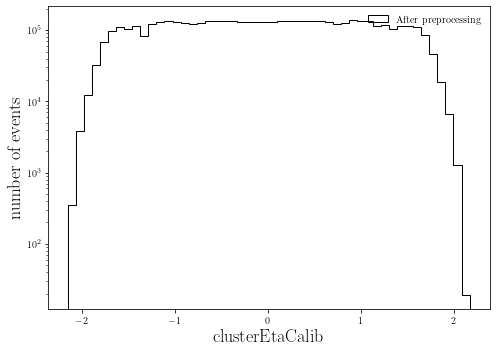

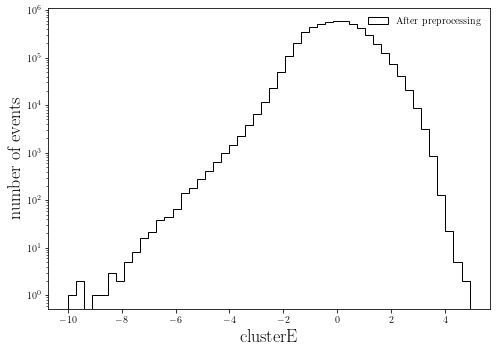

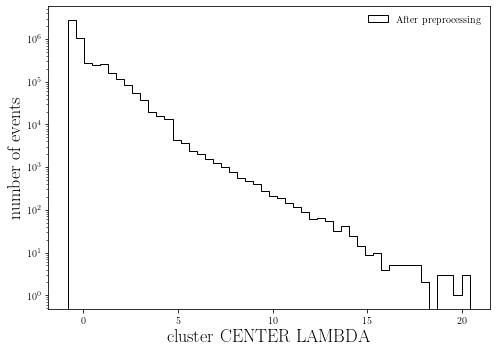

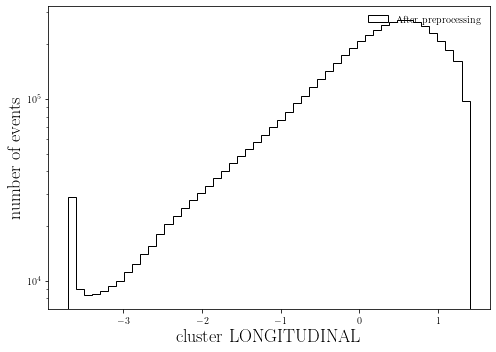

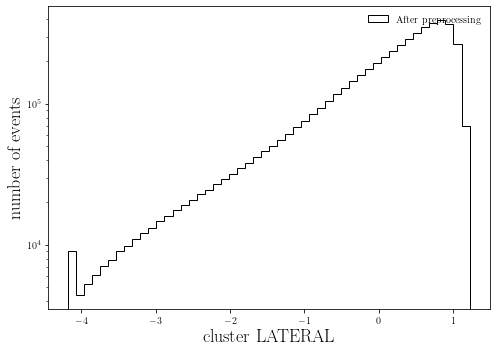

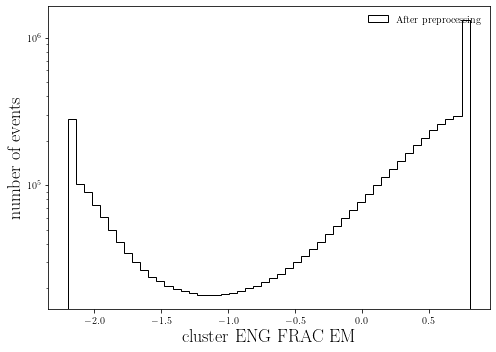

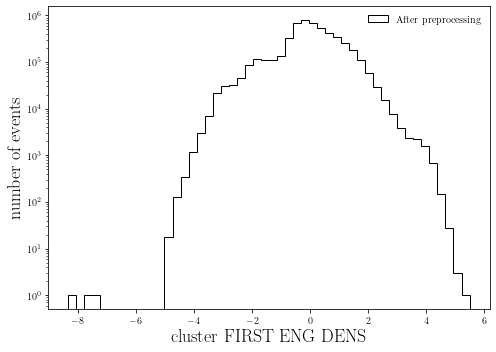

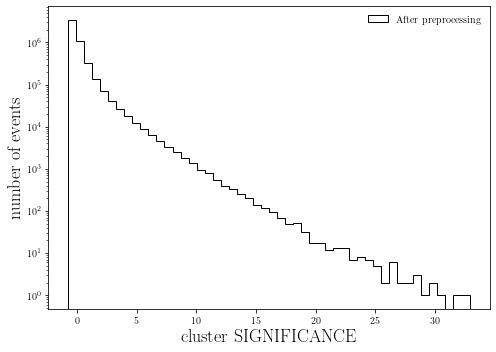

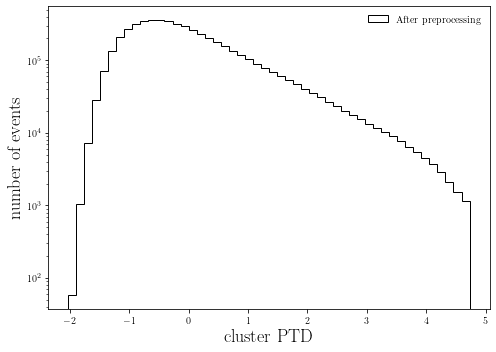

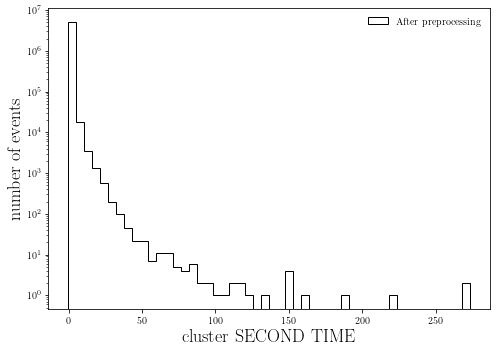

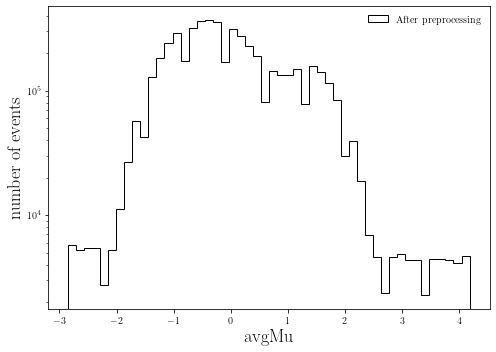

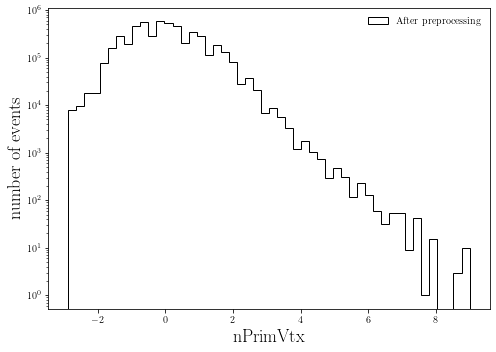

In [17]:
n_bins = 50

for i, name in enumerate(features):
    print(i, name)
    fig, axs = plt.subplots( 1, 1, figsize=(7,5) )
    feature = trn_datf[:, i]
    axs.hist( feature, bins=n_bins, histtype='stepfilled', fill=None, label="After preprocessing" )

    axs.set_xlabel(name.replace("_", " "), fontproperties=axislabelfont )
    axs.set_ylabel("number of events", fontproperties=axislabelfont )
    axs.legend(frameon=False)
    axs.set_yscale('log')

    fig.tight_layout()

## Datasets and dataloaders

Let's construct three different dataloaders which will provide batches of data druing training and validation of our neural network.

In [18]:
class amp_dataset( Dataset ):
    
    def __init__( self, data, amp ):
        self.data = data
        self.amp = amp

    def __len__(self):
        return len(self.amp)

    def __getitem__(self, idx):
        return self.data[idx], self.amp[idx]

In [19]:
trn_dataset = amp_dataset( trn_datfp, trn_amplp.unsqueeze(-1) )
val_dataset = amp_dataset( val_datfp, val_amplp.unsqueeze(-1) )
tst_dataset = amp_dataset( tst_datfp, tst_amplp.unsqueeze(-1) )

In [20]:
trn_dataloader = DataLoader( trn_dataset, batch_size=64, shuffle=True )
val_dataloader = DataLoader( val_dataset, batch_size=64, shuffle=True )
tst_dataloader = DataLoader( tst_dataset, batch_size=64, shuffle=True )

In [21]:
next( iter( trn_dataloader ) )[0].shape

torch.Size([64, 12])

In [22]:
next( iter( trn_dataloader ) )[1].shape

torch.Size([64, 1])

## Building a Bayesian layer

First let's look at the source code for a **basic linear layer** in pytorch:

(https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear)

In [25]:
class Linear(Module):
    
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input: Tensor) -> Tensor:
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

Objects of this class apply a linear transformation to the incoming data: $y = xA^T + b$.

The input arguments are required to initialise the layer, so, in the \_\_init()\_\_ function.  We have:
- in_features: size of each input sample
- out_features: size of each output sample
- bias: If set to ``False``, the layer will not learn an additive bias.  Default: ``True``

The shapes are:
- Input: $(*, H_{in})$ where $*$ means any number of dimensions including none and $H_{in} = \text{in_features}$.
- Output: $(*, H_{out})$ where all but the last dimension are the same shape as the input and $H_{out} = \text{out_features}$.

The layer has attributes:
- weight: the learnable weights of the module of shape $(\text{out_features}, \text{in_features})$. The values are initialized from $\mathcal{U}(-\sqrt{k}, \sqrt{k})$, where $k = \frac{1}{\text{in_features}}$
- bias:   the learnable bias of the module of shape $(\text{out_features})$.  If `bias` is ``True``, the values are initialized from $\mathcal{U}(-\sqrt{k}, \sqrt{k})$ where $k = \frac{1}{\text{in_features}}$.

Examples::

    >>> m = nn.Linear(20, 30)
    
    >>> input = torch.randn(128, 20)
    
    >>> output = m(input)
    
    >>> print(output.size())
    
    torch.Size([128, 30])

From the lecture, we know that in a Bayesian network the weights are replaced by Gaussian distributions, and on a forward pass we get the output by sampling from that distribution.

So the biases are the same as in the linear layer.  But not each weight is a Gaussian distibution and so needs a mean and a variance.  The bias and the mean and variance of the weight distribution will be learnable.  In practice it's easier to work with the log of the variance as it is more stable when optimising the network.

We need to be able to sample from the Gaussian weight distributions, and compute derivatives of the output in order to update the network parameters.  To do this we use something called the 're-parameterisation trick'.  It involves sampling random noise from a unit normal distribution, and then transforming that number using the mean and variance of the weight distribution in this way:
\begin{equation}
w = \mu + \sigma\times r
\end{equation}
where $r$ is a random number sampled from a unit normal distribution (Gaussian with mean and variance equal to one), $\mu$ is the mean of the weight distribution, and $\sigma$ is the standard deviation.  In this way we separate the stochastic part of the function from the parameters defining the distribution.  And so if we take any differentiable function of $x$ (e.g. an activation function), we can compute derivatives of that function with respect to the mean and variance of the weight distribution.

In the `forward` method we then need to implement this reparameterisation trick for the weights, and then apply the same linear transformation as in the standard linear layer.

On each forward pass we need to generate a set of random numbers with the same shape as our means and variances.  Choosing a set of random numbers for the sampling is equivalent to 'sampling' a new neural network from the Bayesian neural network.  And sometimes at the end of the analysis, we will want to keep the same network for testing.  So we don't always want to re-sample the random numbers on each forward pass.  To control this we define a flag called `self.resample`, with default set to ``True``.

We also need a `reset_parameters` function to reset the parameters in the network.  This is standard for layers in pytorch.  We use a slightly different function to do this than is used in the pytorch linear layer, as can be seen below.

From the lecture, you know that the weight distributions require a prior.  The simplest choice for this prior is just a Gaussian distribution with a mean and variance of one.  Results are typically not too sensitive to this prior, as long as the values are within reasonable limits.  For example, $\mathcal{O}(1)$ means and standard deviations.  Going beyond $\mathcal{O}(1)$ numbers just leads to numerical instabilities in the training.  The Bayesian loss function contains a term coming from the KL divergence between the weight distributions in the network and their priors.  So the layers should have some funcitonality to return these values.  The KL divergence for the layer is:
\begin{equation}
\text{KL} = \sum_{\text{weights}} 0.5 \times (  \mu^2 + \sigma^2 - \log\sigma^2 - 1 )
\end{equation}

So let's build the **simplest Bayesian layer** we can.

In [26]:
# Implementation which is easy to understand, but worse than the one presented in the next cell!
class VBLinear_old( Module ):
    # VB -> Variational Bayes
    
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor
    
    def __init__( self, in_features, out_features ):
        super(VBLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.resample = True
        self.bias = Parameter( Tensor( out_features ) )
        self.mu_w = Parameter( Tensor( out_features, in_features ) )
        self.logsig2_w = Parameter( Tensor( out_features, in_features ) )
        self.random = torch.randn_like( self.logsig2_w )
        self.reset_parameters()
        
    def forward( self, input ):
        if self.resample:
            self.random = torch.randn_like( self.logsig2_w )
        s2_w = self.logsig2_w.exp()
        weight = self.mu_w + s2_w.sqrt() * self.random
        return nn.functional.linear( input, weight, self.bias ) #+ 1e-8
    
    def reset_parameters( self ):
        stdv = 1. / np.sqrt( self.mu_w.size(1) )
        self.mu_w.data.normal_( 0, stdv )
        self.logsig2_w.data.zero_().normal_( -9, 0.001 )
        self.bias.data.zero_()
        
    def KL(self):
        kl = 0.5 * ( self.mu_w.pow(2) + self.logsig2_w.exp() - self.logsig2_w - 1 ).sum()
        return kl

In [23]:
# alternative implementation
# using LOCAL repara. trick -> Gives more stable gradients!
class VBLinear(Module):
    def __init__(self, in_features, out_features, prior_prec=1.0, _map=False):
        super(VBLinear, self).__init__()
        self.n_in = in_features
        self.n_out = out_features
        self.map = _map
        self.prior_prec = prior_prec
        self.random = None
        self.bias = nn.Parameter(torch.Tensor(out_features))
        self.mu_w = nn.Parameter(torch.Tensor(out_features, in_features))
        self.logsig2_w = nn.Parameter(torch.Tensor(out_features, in_features))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / np.sqrt(self.mu_w.size(1))
        self.mu_w.data.normal_(0, stdv)
        self.logsig2_w.data.zero_().normal_(-9, 0.001)
        self.bias.data.zero_()

    def reset_random(self):
        self.random = None

    def KL(self):
        logsig2_w = self.logsig2_w.clamp(-20, 11)
        #logsig2_w = self.logsig2_w
        kl = 0.5 * (self.prior_prec * (self.mu_w.pow(2) + logsig2_w.exp())
                    - logsig2_w - 1 - np.log(self.prior_prec)).sum()
        return kl

    def forward(self, input):
        if self.training:
            # local reparameterization trick is more efficient and leads to
            # an estimate of the gradient with smaller variance.
            # https://arxiv.org/pdf/1506.02557.pdf
            mu_out = nn.functional.linear(input, self.mu_w, self.bias)
            logsig2_w = self.logsig2_w.clamp(-20, 11)
            #logsig2_w = self.logsig2_w
            s2_w = logsig2_w.exp()
            var_out = nn.functional.linear(input.pow(2), s2_w)
            return mu_out + var_out.sqrt() * torch.randn_like(mu_out)

        else:
            # maximum a posteriori (MAP)
            if self.map:
                return nn.functional.linear(input, self.mu_w, self.bias)

            #logsig2_w = self.logsig2_w
            logsig2_w = self.logsig2_w.clamp(-20, 11)
            if self.random is None:
                self.random = torch.randn_like(self.logsig2_w)
            s2_w = logsig2_w.exp()
            weight = self.mu_w + s2_w.sqrt() * self.random
            return nn.functional.linear(input, weight, self.bias)

    def __repr__(self):
        return f"{self.__class__.__name__} ({self.n_in}) -> ({self.n_out})"

Let's test the layers, define:

In [24]:
tlr0 = VBLinear( 10, 5 )
tlr1 = VBLinear( 5, 2 )

Now some test data, a batch of 20 vectors with 10 elements each:

In [25]:
x = torch.rand( 20, 10 )

Now pass the data first through layer0 then through layer1:

In [26]:
tlr1( tlr0( x ) )

tensor([[ 0.0731, -0.0680],
        [-0.3280, -0.2078],
        [-0.1487,  0.5553],
        [ 0.4242,  0.2451],
        [ 0.8523, -1.2903],
        [ 0.2822, -0.1944],
        [ 0.0591,  0.4585],
        [-0.0158,  0.4639],
        [ 0.0971,  1.2270],
        [ 0.1857, -0.0851],
        [ 0.2438, -0.0153],
        [ 0.1261, -1.5030],
        [ 0.8615, -0.2456],
        [ 0.0020,  0.3715],
        [-0.3670, -0.1012],
        [ 0.2822,  0.1441],
        [ 0.3318, -0.9216],
        [ 0.9311, -1.1367],
        [ 0.2511,  0.1944],
        [ 0.4933, -1.0691]], grad_fn=<AddBackward0>)

Note this has the correct shape:

In [27]:
tlr1( tlr0( x ) ).shape

torch.Size([20, 2])

Also try running the same data through the layer multiple times, you get different results.  This is because of the sampling in the Bayesian layer.

In [28]:
for i in range(5):
    print(tlr0(x)[0][0])

tensor(0.0622, grad_fn=<SelectBackward0>)
tensor(0.0259, grad_fn=<SelectBackward0>)
tensor(0.0388, grad_fn=<SelectBackward0>)
tensor(0.0597, grad_fn=<SelectBackward0>)
tensor(0.0945, grad_fn=<SelectBackward0>)


Warning! While this implementation of a variational layer is straight forward and easier to understand, there is a much better option: the LOCAL reparameterization trick! I (Michel) can provide a pytroch implementation.

## The Bayesian loss function

There are two parts to the Bayesian loss function:
- The negative log Gaussian
- the KL from the network weights

The second comes from the layers, and the first is defined below.  This negative log Gaussian term acts on the two outputs from the Bayesian neural network:
- the mean
- the variance (which we parameterise as the log variance)

In [29]:
def neg_log_gauss( outputs, targets ):

    mu = outputs[:, 0]
    logsigma2 = outputs[:, 1]
    out = torch.pow( mu - targets, 2 ) / ( 2 * logsigma2.exp() ) + 1./2. * logsigma2
    
    return torch.mean(out)

## Building the neural network

We'll build a simple network with one input and one output layer, and two hidden layers.  We define the dimensions of these layers below.

In [30]:
ipt_dim = len(features)

Now we build a very simple class for our neural network, which we call amp_net.

In [31]:
class bayes_amp_net( Module ):
    
    # default hdn_dim is 30, but can be changed upon initialisation
    def __init__( self, training_size, hdn_dim=50, num_hidden_layers=3):
        
        super( bayes_amp_net, self ).__init__()
        
        # the loss function depends on the amount of training data we have, so we need to store this
        self.training_size = training_size
        
        # the activation layers of the network are not bayesian
        # and we need to be able to access the bayesian layers separately
        
        self.vb_layers = []
        self.all_layers = []
        
        # define the input layer
        vb_layer = VBLinear( ipt_dim, hdn_dim )
        self.vb_layers.append( vb_layer )
        self.all_layers.append( vb_layer )
        self.all_layers.append( nn.ReLU() )
        
        # loop over hidden layers
        for i in range(num_hidden_layers):
            vb_layer = VBLinear( hdn_dim, hdn_dim )
            self.vb_layers.append( vb_layer )
            self.all_layers.append( vb_layer )
            self.all_layers.append( nn.ReLU() )
        
        # define the output layer
        vb_layer = VBLinear( hdn_dim, 2 )
        self.vb_layers.append( vb_layer )
        self.all_layers.append( vb_layer )
        
        # define the model as a Sequential net over all layers
        self.model = nn.Sequential(*self.all_layers)

    # and of course the forward function
    def forward( self, x ):
        out = self.model( x )
        return out
    
    # we need the KL from the bayesian layers to compute the loss function
    def KL( self ):
        kl = 0
        for vb_layer in self.vb_layers:
            kl += vb_layer.KL()
        return kl / self.training_size
    
    # let's put the neg_log_gauss in the network class aswell since it is key to bayesian networks
    def neg_log_gauss( self, outputs, targets ):
        mu = outputs[:, 0]
        logsigma2 = outputs[:, 1]
        out = torch.pow( mu - targets, 2 ) / ( 2 * logsigma2.exp() ) + 1./2. * logsigma2
        return torch.mean(out)

Check if we have a GPU.

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


Initialise the neural network and send to the GPU if we have one.  We can also print the model to see what layers it has.

In [42]:
trn_len = trn_amplp.shape[0]
hdn_dim = 128   ### hidden layer nodes
model = bayes_amp_net( trn_len, hdn_dim=hdn_dim ).to(device)
print(model)

bayes_amp_net(
  (model): Sequential(
    (0): VBLinear (12) -> (128)
    (1): ReLU()
    (2): VBLinear (128) -> (128)
    (3): ReLU()
    (4): VBLinear (128) -> (128)
    (5): ReLU()
    (6): VBLinear (128) -> (128)
    (7): ReLU()
    (8): VBLinear (128) -> (2)
  )
)


Now we can test it briefly by throwing some random numbers into it.

In [43]:
X = torch.rand(5, 12, device=device)

Passing the numbers through the Bayesian network gives us different outputs each time we run it:

In [44]:
model( X )

tensor([[-0.0369,  0.0146],
        [-0.0586, -0.0629],
        [-0.0740,  0.0281],
        [-0.0525, -0.0557],
        [-0.0627,  0.0960]], grad_fn=<AddBackward0>)

Note again that the output has the correct shape:

In [45]:
model( X ).shape

torch.Size([5, 2])

The predicitons of the full Bayesian network should vary with each forward pass because of the weight sampling

In [46]:
# print predictions for the same input data
for i in range(5):
    print(model( X )[0])

tensor([-0.0432,  0.0226], grad_fn=<SelectBackward0>)
tensor([0.0408, 0.0191], grad_fn=<SelectBackward0>)
tensor([-0.1033,  0.0614], grad_fn=<SelectBackward0>)
tensor([-0.0490, -0.0228], grad_fn=<SelectBackward0>)
tensor([-0.0214,  0.0323], grad_fn=<SelectBackward0>)


Looks like it's working.

## Optimising (training) the neural network

The Bayesian loss function has two terms which we have already definedl; the negative los Gaussian, and the KL divergence between the network and the network prior.  The latter comes from the KL divergence over the weights in the network.

Now we can write a training loop for a single epoch.

In [47]:
def train_epoch( dataloader, model, optimizer ):

    size = len( dataloader.dataset )
    model.train()
    loss_tot, kl_tot, neg_log_tot = 0.0, 0.0, 0.0
    
    for batch, (X, y) in enumerate( dataloader ):
        
        # pass data through network
        pred = model(X)
        
        # compute loss
        nl = model.neg_log_gauss( pred, y.reshape(-1) )
        kl = model.KL()
        loss = nl + kl
        
        # reset gradients in optimizer
        optimizer.zero_grad()
        
        # compute gradients
        loss.backward()
        
        # update weights with optimizer
        optimizer.step()
        
        # print the training loss every 100 updates
        if batch % 100 == 0:
            current = batch * len( X )
            print(f"current batch loss: {loss:>8f} KL: {kl:>8f} Neg-log {nl:>8f}  [{current:>5d}/{size:>5d}]")

To monitor the performance of the network on the regression task we want to calculate the loss of both the training data and the validation data on the same network, so we have the following functions:

In [48]:
def val_pass( dataloader, model ):
    
    size = len( dataloader.dataset )
    num_batches = len( dataloader )
    nls = 0.0
    kls = 0.0
    vls = 0.0
    mse = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X, y in dataloader:
            pred = model( X )
            nl = model.neg_log_gauss( pred, y.reshape(-1) )
            kl = model.KL()
            vl = nl.item() + kl.item()
            mse += torch.mean((pred[:, 0] - y.reshape(-1))**2)
            nls += nl
            kls += kl
            vls += vl

    nls /= num_batches
    kls /= num_batches
    vls /= num_batches
    mse /= num_batches
    print( f"avg val loss per batch: {vls:>8f} KL: {kls:>8f} Neg-log {nls:>8f} MSE {mse:>8}" )
    
    return nls, kls, vls, mse

def trn_pass( dataloader, model ):
    
    size = len( dataloader.dataset )
    num_batches = len( dataloader )
    nls = 0.0
    kls = 0.0
    tls = 0.0
    mse = 0.0

    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        for X, y in dataloader:
            pred = model( X )
            nl = model.neg_log_gauss( pred, y.reshape(-1) )
            kl = model.KL()
            tl = nl.item() + kl.item()
            mse += torch.mean((pred[:, 0] - y.reshape(-1))**2)
            nls += nl
            kls += kl
            tls += tl

    nls /= num_batches
    kls /= num_batches
    tls /= num_batches
    mse /= num_batches
    print( f"avg trn loss per batch: {tls:>8f} KL: {kls:>8f} Neg-log {nls:>8f} MSE {mse:>8}" )
    
    return nls, kls, tls, mse

Now we can train the model! The learning rate has been reduced from the (default) 0.001 to 0.0001. The presently used batch size is 128 (potentially larger batches?) and we are training for 100 epochs. 

In [ ]:
# a useful function to present things clearer
def seperator():
    print( f"----------------------------------------------- {time.ctime()}" )

##########################
# hyper parameters
batch_size = 2048
epochs = 10
##hdn_dim = 10
learning_rate = 0.0001
file_name_base = f'{file_model_prefix}_e{epochs}_b{batch_size}.{file_model_version}'
##########################

trn_dataloader = DataLoader( trn_dataset, batch_size=batch_size, shuffle=True )
val_dataloader = DataLoader( val_dataset, batch_size=batch_size, shuffle=True )
tst_dataloader = DataLoader( tst_dataset, batch_size=batch_size, shuffle=True )

# re-initialise the model
trn_len = trn_amplp.shape[0]
print(f"Training dataset length: {trn_len}")
model = bayes_amp_net( trn_len, hdn_dim=hdn_dim ).to(device)

# re-initialise the optimizer
optimizer = torch.optim.Adam( model.parameters(), lr=learning_rate )

# print architecture
seperator()
print( "model architecture ")
seperator()
print( model )

# track train and val losses
trn_nl_losses = []
trn_kl_losses = []
trn_losses = []
trn_mse_losses = []
val_nl_losses = []
val_kl_losses = []
val_losses = []
val_mse_losses = []

for t in range(epochs):
    seperator()
    print( f"Epoch {t+1}" )
    seperator()
    train_epoch( trn_dataloader, model, optimizer )
    seperator()
    trn_nl_loss, trn_kl_loss, trn_loss, trn_mse_loss = trn_pass( trn_dataloader, model )
    trn_nl_losses.append( trn_nl_loss )
    trn_kl_losses.append( trn_kl_loss )
    trn_losses.append( trn_loss )
    trn_mse_losses.append(trn_mse_loss)
    seperator()
    val_nl_loss, val_kl_loss, val_loss, val_mse_loss = val_pass( val_dataloader, model )
    val_nl_losses.append( val_nl_loss )
    val_kl_losses.append( val_kl_loss )
    val_losses.append( val_loss )
    val_mse_losses.append( val_mse_loss )
    seperator()
    if t == 0 or (t+1) % 10 == 0:
            fname = '{0}_{1:03d}.model.{2}'.format(file_name_base,t+1,file_model_ext)
            torch.save(model, fname)
            sname = '{0}_{1:03d}.state.{2}'.format(file_name_base,t+1,file_model_ext)
            torch.save(model.state_dict(), sname)
            # -- FIXME cname = '{0}_{1:03d}.script.{2}'.format(file_name_base,t+1,file_model_ext)
            # -- FIXME model_scripted = jtorch.script(model)
            # -- FIXME model_scripted.save(cname)
    print( "|" )
fname = '{0}_final.model.{1}'.format(file_name_base,file_model_ext)
torch.save(model, fname)
sname = '{0}_final.state.{1}'.format(file_name_base,file_model_ext)
torch.save(model.state_dict(), sname)
# -- FIXME cname = '{0}_final.script.{1}'.format(file_name_base,file_model_ext)
# -- FIXME model_scripted = jtorch.script(model)
# -- FIXME model_scripted.save(cname)
print("Done!")

Training dataset length: 5135091
----------------------------------------------- Wed Sep  7 07:52:14 2022
model architecture 
----------------------------------------------- Wed Sep  7 07:52:14 2022
bayes_amp_net(
  (model): Sequential(
    (0): VBLinear (12) -> (128)
    (1): ReLU()
    (2): VBLinear (128) -> (128)
    (3): ReLU()
    (4): VBLinear (128) -> (128)
    (5): ReLU()
    (6): VBLinear (128) -> (128)
    (7): ReLU()
    (8): VBLinear (128) -> (2)
  )
)
----------------------------------------------- Wed Sep  7 07:52:14 2022
Epoch 1
----------------------------------------------- Wed Sep  7 07:52:14 2022
current batch loss: 1.474377 KL: 0.039735 Neg-log 1.434643  [    0/5135091]
current batch loss: 0.105078 KL: 0.039723 Neg-log 0.065355  [204800/5135091]
current batch loss: -0.123831 KL: 0.039716 Neg-log -0.163547  [409600/5135091]
current batch loss: -0.214572 KL: 0.039713 Neg-log -0.254284  [614400/5135091]
current batch loss: -0.317643 KL: 0.039711 Neg-log -0.357354  [819

## Plot the train and validation losses as a function of the epochs

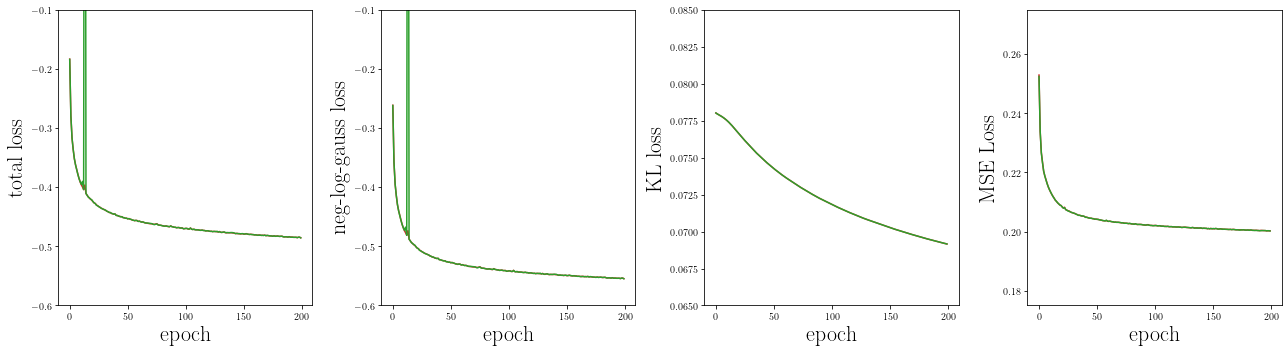

In [57]:
fig, axs = plt.subplots( 1, 4, figsize=(18,5) )

c1 = 'tab:red'
c2 = 'tab:green'

axs[0].plot( trn_losses, label="train", color=c1 )
axs[0].plot( val_losses, label="val", color=c2 )
#axs[0].set_yscale('log')
axs[0].set_xlabel( "epoch", fontproperties=axislabelfont )
axs[0].set_ylabel( "total loss", fontproperties=axislabelfont )
axs[0].set_ylim([-0.6, -0.1])
#axs[0].set_yscale('log')

axs[1].plot( trn_nl_losses, label="train", color=c1 )
axs[1].plot( val_nl_losses, label="val", color=c2 )
#axs[1].set_yscale('log')
axs[1].set_xlabel( "epoch", fontproperties=axislabelfont )
axs[1].set_ylabel( "neg-log-gauss loss", fontproperties=axislabelfont )
axs[1].set_ylim([-0.6, -0.1])

axs[2].plot( trn_kl_losses, label="train", color=c1 )
axs[2].plot( val_kl_losses, label="val", color=c2 )
#axs[2].set_yscale('log')
axs[2].set_xlabel( "epoch", fontproperties=axislabelfont )
axs[2].set_ylabel( "KL loss", fontproperties=axislabelfont )
axs[2].set_ylim([0.065,0.085])

axs[3].plot( trn_mse_losses, label="train", color=c1 )
axs[3].plot( val_mse_losses, label="val", color=c2 )
#axs[3].set_yscale('log')
axs[3].set_xlabel( "epoch", fontproperties=axislabelfont )
axs[3].set_ylabel( "MSE Loss", fontproperties=axislabelfont )
axs[3].set_ylim([0.175,0.275])
#axs[3].legend( loc='best', prop=tickfont )

fig.tight_layout()

We can see that both the train and validation losses are being reduced during training, the model is fitting well!

## Study the results

Now we want to get some visualisation of how well our amplitude regression has worked.

The simplest thing we can do is to pass our data through the neural network to get a predicted labels for each event, then histogram this and compare it to the histogram of the true labels.

In [58]:
def get_prediction( model, dataloader, n_monte=30):
    
    # we don't need gradients here since we only use the forward pass
    with torch.no_grad():
        
        # sample from weight distributions
        amps_samples = []
        sigma2_samples = []
        for i in range(n_monte):
            print(f"Evaluating prediction: {i+1} / {n_monte}")
            
            # go through dataset
            amps = []
            sigma2 = []
            for X, y in dataloader:
                pred = model( X ).detach().numpy()
                amps.extend(pred[:, 0]) # dimensions: [batch_size, 2]
                sigma2.extend(np.exp(pred[:, 1]))

            amps_samples.append(amps)
            sigma2_samples.append(sigma2)
           
    # dimensionaility (n_monte, batch_size)
    amps_samples = np.stack(amps_samples, axis=0)
    sigma2_samples = np.stack(sigma2_samples, axis=0)
                
    return amps_samples, sigma2_samples


In [59]:
##################
batch_size = 10000
n_monte = 30
##################

# TURN OFF shuffeling to not mess up the weight sampling!
trn_dataloader = DataLoader( trn_dataset, batch_size=batch_size, shuffle=False )
val_dataloader = DataLoader( val_dataset, batch_size=batch_size, shuffle=False )
tst_dataloader = DataLoader( tst_dataset, batch_size=batch_size, shuffle=False )

# dimensionality is (n_monte, batch_size)
pred_trn_ampls_samples, sigma2_trn_samples = get_prediction( model, trn_dataloader, n_monte)
pred_val_ampls_samples, sigma2_val_samples = get_prediction( model, val_dataloader, n_monte)

# compute mean prediction, standard deviation of predictions and mean sigma-output
pred_trn_ampls = np.mean(pred_trn_ampls_samples, axis=0) # mean prediction
pred_trn_ampls_std = np.std(pred_trn_ampls_samples, axis=0)
pred_trn_ampls_std_stoch = np.sqrt(np.mean(sigma2_trn_samples, axis=0))
pred_trn_ampls_std_tot = np.sqrt(pred_trn_ampls_std**2 + pred_trn_ampls_std_stoch**2)

# same for validation data
pred_val_ampls = np.mean(pred_val_ampls_samples, axis=0) # mean prediction
pred_val_ampls_std = np.std(pred_val_ampls_samples, axis=0)
pred_val_ampls_std_stoch = np.sqrt(np.mean(sigma2_val_samples, axis=0))
pred_val_ampls_std_tot = np.sqrt(pred_val_ampls_std**2 + pred_val_ampls_std_stoch**2)

print("Mean std pred: ", np.mean(pred_trn_ampls_std))
print("Mean std stoch: ", np.mean(pred_trn_ampls_std_stoch))


Evaluating prediction: 1 / 30
Evaluating prediction: 2 / 30
Evaluating prediction: 3 / 30
Evaluating prediction: 4 / 30
Evaluating prediction: 5 / 30
Evaluating prediction: 6 / 30
Evaluating prediction: 7 / 30
Evaluating prediction: 8 / 30
Evaluating prediction: 9 / 30
Evaluating prediction: 10 / 30
Evaluating prediction: 11 / 30
Evaluating prediction: 12 / 30
Evaluating prediction: 13 / 30
Evaluating prediction: 14 / 30
Evaluating prediction: 15 / 30
Evaluating prediction: 16 / 30
Evaluating prediction: 17 / 30
Evaluating prediction: 18 / 30
Evaluating prediction: 19 / 30
Evaluating prediction: 20 / 30
Evaluating prediction: 21 / 30
Evaluating prediction: 22 / 30
Evaluating prediction: 23 / 30
Evaluating prediction: 24 / 30
Evaluating prediction: 25 / 30
Evaluating prediction: 26 / 30
Evaluating prediction: 27 / 30
Evaluating prediction: 28 / 30
Evaluating prediction: 29 / 30
Evaluating prediction: 30 / 30
Evaluating prediction: 1 / 30
Evaluating prediction: 2 / 30
Evaluating predicti

First for the training data:

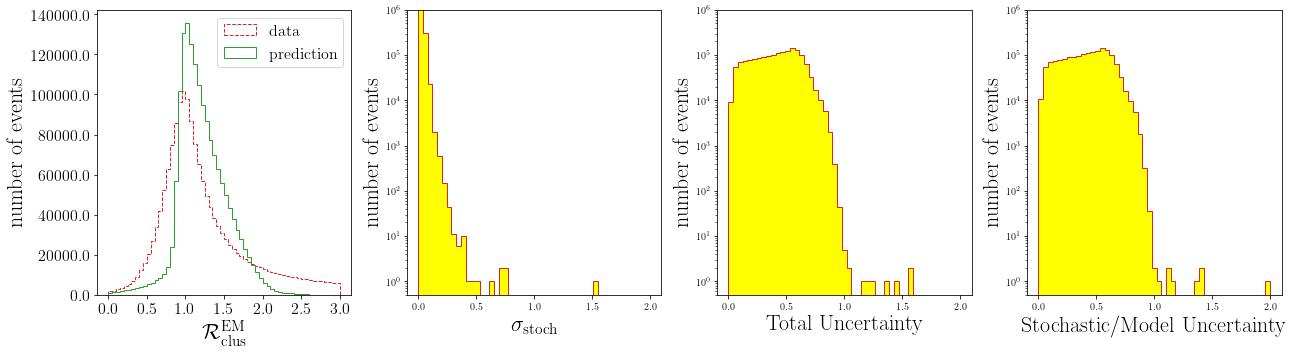

In [60]:
fig, axs = plt.subplots( 1, 4, figsize=(18,5) )

c1 = 'tab:red'
c2 = 'tab:green'

(n1, bins, patches1 ) = axs[0].hist( trn_amp, histtype='stepfilled', bins=60, fill=None, edgecolor=c1, label="data", ls="--" )
(n2, bins, patches2 ) = axs[0].hist( pred_trn_ampls, histtype='stepfilled',fill=None, edgecolor=c2, label="prediction", bins=bins )

bins1= np.linspace(0, 2., 50)
bins2= np.linspace(0, 2., 50)
bins3= np.linspace(0, 2., 50)
c3 = 'tab:yellow'
(n3, bins, patches3 ) = axs[1].hist( pred_trn_ampls_std, bins=bins1, histtype='stepfilled', color='yellow', edgecolor=c1, label="train data", ls="-" )
(n4, bins, patches4 ) = axs[2].hist( pred_trn_ampls_std_tot, bins=bins2, histtype='stepfilled', color='yellow', edgecolor=c1, label="train data", ls="-" )
(n5, bins, patches5 ) = axs[3].hist( pred_trn_ampls_std_stoch, bins=bins3, histtype='stepfilled', color='yellow', edgecolor=c1, label="train data", ls="-" )

#axs[0].set_yscale( 'log' )
axs[0].set_xlabel( "$\mathcal{R}_{\mathrm{clus}}^{\mathrm{EM}}$", fontproperties=axislabelfont )
axs[0].set_ylabel( "number of events", fontproperties=axislabelfont )
xticks = axs[0].get_xticks()
axs[0].set_xticklabels( xticks, fontproperties=tickfont )
yticks = axs[0].get_yticks()
axs[0].set_yticklabels( yticks, fontproperties=tickfont )
axs[0].legend( loc='upper right', prop=tickfont )

axs[1].set_yscale('log')
axs[1].set_ylim([0.5,1e+6])
axs[1].set_xlabel( "$\sigma_{\mathrm{stoch}}$", fontproperties=axislabelfont )
axs[1].set_ylabel( "number of events", fontproperties=axislabelfont )
#axs[1].legend( loc='best', prop=tickfont )

axs[2].set_yscale('log')
axs[2].set_ylim([0.5,1e+6])
axs[2].set_xlabel( "Total Uncertainty ", fontproperties=axislabelfont )
axs[2].set_ylabel( "number of events", fontproperties=axislabelfont )
#axs[2].legend( loc='best', prop=tickfont )

axs[3].set_ylim([0.5,1e+6])
axs[3].set_yscale('log')
axs[3].set_xlabel( "Stochastic/Model Uncertainty", fontproperties=axislabelfont )
axs[3].set_ylabel( "number of events", fontproperties=axislabelfont )
#axs[3].legend( loc='best', prop=tickfont )


fig.tight_layout()

We can see that the predicted amplitudes show roughly the same shape as the true ampltiudes given by the training dataset. Much better results could be achieve with a longer training, a more complex architetcure (deeper and/or wider layers) and a larger training dataset. The 3 other panels show how the 2 types of uncertainties (and the total uncertainty) are distributed.

Let's try to understand if the uncertainty estimates are meaningful. If the uncertainty is well calibrated and the error is Gaussian distributed, the event-level expression $(y -y^{\mathrm{true}}) / \sigma_{\mathrm{unc}} $ should  follow a standard normal distribution with mean 0 and width 1. 

Maximum position for pull:  -0.04081632653061229
Mean position for pull:  -0.13020707777463864


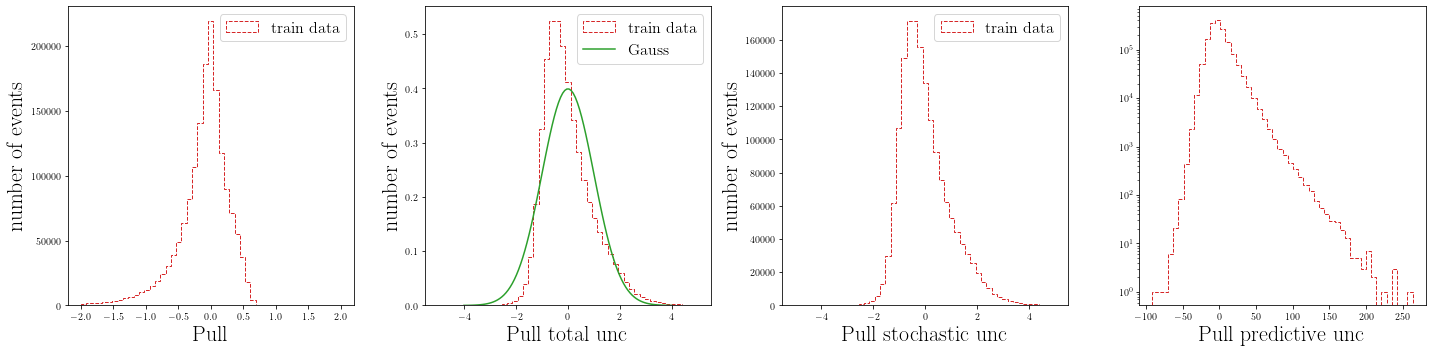

In [61]:
# be careful. All of this is without reversing preprocessing!

fig, axs = plt.subplots( 1, 4, figsize=(20,5) )
from scipy.stats import norm

c1 = 'tab:red'
c2 = 'tab:green'

n_bins = 50
bins = np.linspace(-5, 5, n_bins)

pull = (trn_amp - pred_trn_ampls) / trn_amp
pull_normalized_tot = (trn_amp - pred_trn_ampls) / pred_val_ampls_std_tot
pull_normalized_stoch = (trn_amp - pred_trn_ampls) / pred_val_ampls_std_stoch
pull_normalized = (trn_amp - pred_trn_ampls) / pred_val_ampls_std

(n1, bins1, patches1 ) = axs[0].hist( pull, histtype='stepfilled', bins=np.linspace(-2, 2, 50), fill=None, edgecolor=c1, label="train data", ls="--" )
(n2, bins2, patches2 ) = axs[1].hist( pull_normalized_tot, histtype='stepfilled', bins=np.linspace(-5, 5, n_bins), fill=None, edgecolor=c1, label="train data", ls="--", density=True )
(n3, bins3, patches3 ) = axs[2].hist( pull_normalized_stoch, histtype='stepfilled', bins=np.linspace(-5, 5, n_bins), fill=None, edgecolor=c1, label="train data", ls="--" )
(n4, bins4, patches4 ) = axs[3].hist( pull_normalized, histtype='stepfilled', bins=n_bins, fill=None, edgecolor=c1, label="train data", ls="--" )

print("Maximum position for pull: ", bins1[np.argmax(n1)])
print("Mean position for pull: ", np.mean(pull))

# plot Gaussian with mean=0 and std=1
x = np.linspace(-4, 4, 100)
y = norm.pdf(x, 0, 1)
axs[1].plot(x, y, label="Gauss", color="C2")

axs[0].set_xlabel( "Pull", fontproperties=axislabelfont )
axs[0].set_ylabel( "number of events", fontproperties=axislabelfont )
axs[0].legend( loc='best', prop=tickfont )

axs[1].set_xlabel( "Pull total unc", fontproperties=axislabelfont )
axs[1].set_ylabel( "number of events", fontproperties=axislabelfont )
axs[1].legend( loc='best', prop=tickfont )

#axs[2].set_yscale( 'log' )
axs[2].set_xlabel( "Pull stochastic unc", fontproperties=axislabelfont )
axs[2].set_ylabel( "number of events", fontproperties=axislabelfont )
axs[2].legend( loc='best', prop=tickfont )

axs[3].set_yscale( 'log' )
axs[3].set_xlabel( "Pull predictive unc", fontproperties=axislabelfont )

fig.tight_layout()

And then for the test data.....

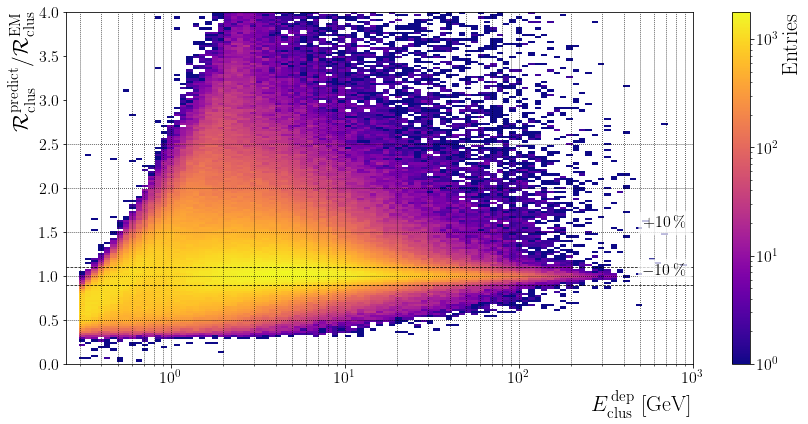

In [187]:
import matplotlib as mpl

fig, axs = plt.subplots(1,1,figsize=(12,6))

x_min = 0.25    ### 0.1
x_max = 1000.  ### 5000.

y_min = 0.
y_max = 4.

x_bins = np.geomspace(x_min, x_max, 100)
y_bins = np.linspace(y_min, y_max, 160)

r_resp = pred_trn_ampls/ trn_amp

###plt.hist2d(devals,r_resp,bins=[x_bins,y_bins],norm=mpl.colors.LogNorm(),cmap=mpl.cm.YlOrBr)
plt.hist2d(devals,r_resp,bins=[x_bins,y_bins],norm=mpl.colors.LogNorm(),cmap=mpl.cm.plasma)

cbar = plt.colorbar()
### axs.set_ylim([0.,4.])
axs.tick_params(axis='both',labelsize=axisfontsize)
axs.set_xscale('log')
axs.set_xlabel('$E_{\mathrm{clus}}^{\,\mathrm{dep}}\;[\mathrm{GeV}]$',fontproperties=axislabelfont,loc='right')
axs.set_ylabel('$\mathcal{R}_{\mathrm{clus}}^{\mathrm{predict}}/\mathcal{R}_{\mathrm{clus}}^{\mathrm{EM}}$',fontproperties=axislabelfont,loc='top')

cbar.set_label('Entries',fontproperties=axislabelfont,loc='top')
cbar.ax.tick_params(labelsize=axisfontsize)

for h in range(5,30,5):
    plt.axhline(h/10,color='black',lw=0.75,linestyle='dotted')
    
plt.axhline(0.9, color='black',lw=0.75,linestyle='dashed' )
plt.axhline(1.1, color='black',lw=0.75,linestyle='dashed' )

for expo in range(0,5):                          ###[ 0, 1, 2, 3, 4 ]:
    for m in range(1,10):                        ###[ 1, 2, 3, 4, 5, 6, 7, 8, 9 ]:
            xl = m * 10**(expo-1)
            if xl > x_min and xl < x_max:
                plt.axvline(xl,color='black',lw=0.75,linestyle='dotted')

uptxt = '$+10\,\%$'
dntxt = '$-10\,\%$'

tbox = dict(boxstyle='round',facecolor='white',linestyle=' ',alpha=0.75)
axs.text(0.99,0.4,uptxt,verticalalignment='center',horizontalalignment='right',transform=axs.transAxes,bbox=tbox,fontproperties=axislabelfont,size=16)
axs.text(0.99,0.265,dntxt,verticalalignment='center',horizontalalignment='right',transform=axs.transAxes,bbox=tbox,fontproperties=axislabelfont,size=16)
                    
##plt.axvline(1,   color='black',lw=0.75,linestyle='dotted')
##plt.axvline(10,  color='black',lw=0.75,linestyle='dotted')
##plt.axvline(100, color='black',lw=0.75,linestyle='dotted')
##plt.axvline(1000,color='black',lw=0.75,linestyle='dotted')
##axs.patch.set_facecolor('lightgrey')

fig.tight_layout()


We see two populations, one with $\langle\mathcal{R}_{\mathrm{clus}}^{\mathrm{predict}}/\mathcal{R}_{\mathrm{clus}}^{\mathrm{EM}}\rangle(E_{\mathrm{clus}}^{\,\mathrm{dep}}) \approx 1$ for $E_{\mathrm{clus}}^{\,\mathrm{dep}} \gtrsim 1\,\mathrm{GeV}$ indicating successful training, and one with $\langle\mathcal{R}_{\mathrm{clus}}^{\mathrm{predict}}/\mathcal{R}_{\mathrm{clus}}^{\mathrm{EM}}\rangle(E_{\mathrm{clus}}^{\,\mathrm{dep}}) \sim \log_{10}^{x} (E_{\mathrm{clus}}^{\,\mathrm{dep}})$, with $x \gtrsim 1$, for $300\,\mathrm{MeV} < E_{\mathrm{clus}}^{\,\mathrm{dep}} \lesssim 3\,\mathrm{GeV}$, where the network could not learn the response $\mathcal{R}_{\mathrm{clus}}^{\mathrm{EM}}$. The features of the topo-clusters in the latter poplation need to be further investigated. 

In [141]:
print(f'Number of features {labels.shape}')

trn_dat_orig = trn_datf * stds + means

for idx, lname in enumerate(features):
    ## invert transformation
    if lname == 'clusterE' or lname == 'cluster_FIRST_ENG_DENS':
            length = len(trn_dat_orig[:,idx])
            print(f"check validity of {length} data words in column {lname}")
            for j in range(length):
                if trn_dat_orig[j,idx] == -20:
                    trn_dat_orig[j,idx] = 0
                    print(f"{lname}: data at index {j} == -20, fixed at {trn_dat_orig[j,idx]}")
#                elif trn_datf[j,idx] < 0:
#                    trn_datf[j,idx] = -20
#                    print(f"{lname}: data at index {j} < 0, fixed at {trn_datf[j,idx]}")
                else:
                    trn_dat_orig[j,idx] = trn_dat_orig[j,idx]**10
            # trn_datf_i = np.log10(trn_datf[:,idx]) if tran_datf[:,idx] > 0 else 
            # trn_datf[:,idx] = trn_datf_i
            print(f"transformed label {lname} (pow(10))")


Number of features (1609176,)
check validity of 1609176 data words in column clusterE
transformed label clusterE (pow(10))
check validity of 1609176 data words in column cluster_FIRST_ENG_DENS
transformed label cluster_FIRST_ENG_DENS (pow(10))


In [1]:
hdict = {
            'clusterEtaCalib'        : [ np.linspace(-3.05,3.05,61)   , '$y_{\mathrm{clus}}$', 'linear' ],           
            'clusterE'               : [ np.geomspace(0.001,5000,500) , '$E_{\mathrm{clus}}^{\mathrm{EM}}\;\;[\mathrm{GeV}]$', 'log' ],
            'cluster_CENTER_LAMBDA'  : [ np.geomspace(0.1,10000,100)  , '$\lambda_{\mathrm{clus}}\;\;[\mathrm{mm}]$', 'log' ],
            'cluster_LONGITUDINAL'   : [ np.linspace(-0.05,1.05,110)  , '$\\langle m_{\mathrm{long}}^{2}\\rangle$', 'linear' ],
            'cluster_LATERAL'        : [ np.linspace(-0.05,1.05,110)  , '$\\langle m_{\mathrm{lat}}^{2}\\rangle$', 'linear' ],
            'cluster_ENG_FRAC_EM'    : [ np.linspace(-0.05,1.05,110)  , '$f_{\mathrm{clus}}^{\mathrm{emc}}$', 'linear' ],
            'cluster_FIRST_ENG_DENS' : [ np.geomspace(1e5,1e+10,500)  , '$\\langle\\rho_{\mathrm{cell}}\\rangle\;\;[\mathrm{GeV}\\times\mathrm{mm}^{-3}]$', 'log' ],
            'cluster_SIGNIFICANCE'   : [ np.linspace(0.,200,200)      , '$\zeta_{\mathrm{clus}}^{\mathrm{EM}}$', 'linear' ],
            'cluster_PTD'            : [ np.linspace(-0.05,1.05,110)  , '$p_{\mathrm{T}}D$', 'linear' ],
            'cluster_SECOND_TIME'    : [ np.geomspace(1e-4,1e+4,100)  , '$\sigma_{t}^{2}\;\;[\mathrm{ns}^{2}]$', 'log' ],
            'avgMu'                  : [ np.linspace(-0.5,80.5,81)    , '$\\langle\mu\\rangle$', 'linear' ],
            'nPrimVtx'               : [ np.linspace(-0.5,50.5,51)    , '$N_{\mathrm{PV}}$', 'linear' ],
            'ResponseEM'             : [ ybins                        , '$\\mathcal{R}_{\mathrm{clus}}^{\mathrm{EM}}$', 'linear' ],
    }

fig, axs = plt.subplots(ncols=1,nrows=len(features),figsize=(12,6*len(features)))

for idx, name in enumerate(features):
    if name in hdict:
        axbins, axtitle, axmode = hdict[name] 
        dplot = axs[idx].hist2d(trn_dat_orig[:,idx],r_resp,bins=[axbins,y_bins],norm=mpl.colors.LogNorm(),cmap=mpl.cm.plasma,cmin=1)
        #cbar  = plt.colorbar(dplot.cmap)
        axs[idx].tick_params(axis='both',labelsize=axisfontsize)
        axs[idx].set_xscale(axmode)
        print( 'title:{tit:80s} mode:{mod:6s}'.format(tit=axtitle,mod=axmode) )
        axs[idx].set_xlabel(axtitle,fontproperties=axislabelfont,loc='right')
        axs[idx].set_ylabel('$\mathcal{R}_{\mathrm{clus}}^{\mathrm{predict}}/\mathcal{R}_{\mathrm{clus}}^{\mathrm{EM}}$',fontproperties=axislabelfont,loc='top')
        axs[idx].grid(axis='both',which='major',lw=0.75,color='black',linestyle='dotted')
        axs[idx].axhline(0.9, color='black',lw=0.75,linestyle='dashed' )
        axs[idx].axhline(1.1, color='black',lw=0.75,linestyle='dashed' )
        #cbar.set_label('Entries',fontproperties=axislabelfont,loc='top')
        #cbar.ax.tick_params(labelsize=axisfontsize)
        #for h in range(5,30,5):
        #    axs[idx].axhline(h/10,color='black',lw=0.75,linestyle='dash')

fig.tight_layout()

NameError: name 'np' is not defined